In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.path.abspath(__file__)), '../..')))
import tensorflow as tf
import math
from tqdm import tqdm
import numpy as np
import time
import cv2
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import scipy as scipy
from collections import Counter
from Erosion import crop_rice_grains
import uuid
import gc


from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input,Dense, Conv2D,GlobalAveragePooling2D,Dropout,Flatten,BatchNormalization,Concatenate,InputLayer,AveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import AdamW


%matplotlib inline

2025-03-18 16:33:02.993408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742290383.010157  490230 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742290383.015326  490230 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 16:33:03.033988: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Initialize Defect Model

In [2]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

config = base_model.get_config()
new_model = tf.keras.models.Model.from_config(config) # <- new_model architecture

x_model = new_model.output
# x_model = data_augmentation(x_model)  
x_model = GlobalAveragePooling2D()(x_model)
x_model = BatchNormalization()(x_model)
x_model = Dropout(0.3)(x_model)
x_model = Dense(128,activation='relu')(x_model)
x_model = BatchNormalization()(x_model)
x_model = Dense(128,activation='relu')(x_model)
x_model = Dropout(0.3)(x_model)
x_model = Dense(64,activation='relu')(x_model)
x_model = Dropout(0.3)(x_model)

predictions = Dense(5, activation='softmax')(x_model)
model = Model(inputs=new_model.input, outputs=predictions)

model.load_weights('/media/new_volumn/MP_DEFECT/models/defect/modelsB0V4.keras')


I0000 00:00:1742290393.014230  490230 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22170 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:02:00.0, compute capability: 8.9


# Load dataset

In [ ]:
def find_npz_files(base_dirs):
    npz_paths = []

    for base_dir in base_dirs:
        for root, dirs, files in os.walk(base_dir):  # Recursively walk through subdirectories
            for file in files:
                if file.endswith('.npz'):  # Check if the file ends with .npz
                    npz_paths.append(os.path.join(root, file))  # Append the full path to the list

    return npz_paths

path_to_hovernet = "/media/nas/MP/segmentation/hovernet/"
# List of base folders you want to search through
base_folders = [
    "Mandi_Wise_Scanned_Images/",
    "New Season Paddy  Dec2024/",
    "PNG_Paddy04-2024/",
    "PNG_Paddy07-2024/"
]

all_npz_files = find_npz_files([path_to_hovernet + base_folder for base_folder in base_folders])

In [4]:
len(all_npz_files)

627

In [5]:
def transform(images):
    X_test_resized = tf.image.resize(images['kernel_pics'], (224, 224))

    # # Normalize images to the range [0, 1]
    X_test_normalized = X_test_resized / 255.0

    return np.array(X_test_normalized)

In [ ]:
# A set to keep track of generated UUIDs for uniqueness check
generated_uuids = set()

def evaluate(X_test, npz_prefix, npz_filename):

    list_normal_rice = []

    data_dict = [
                    'broke',
                    'dual',
                    'half',
                    'normal',
                    'over'
                ]
    # Perform batch prediction
    Y_pred = model.predict(X_test, verbose=0) 
    y_pred = np.argmax(Y_pred, axis=1)  # Get class indices for the whole batch

    # Set base evaluation directory
    base_dir = "/media/new_volumn/SimDINO/AllIndianDefects_Yolo/"
    os.makedirs(base_dir, exist_ok=True)

    # Training data directory for embeddings
    training_dir = "/media/new_volumn/SimDINO/images_india_cleaned_yolo/train/"
    os.makedirs(training_dir, exist_ok=True)

    for i, (image, pred_class) in enumerate(zip(X_test, y_pred)):
        class_label = data_dict[pred_class]  # Get class name from index

        # Define directory for defect class
        defect_class_dir = os.path.join(base_dir, class_label)
        os.makedirs(defect_class_dir, exist_ok=True)

        unique_id = uuid.uuid4().hex
        while unique_id in generated_uuids:
            unique_id = uuid.uuid4().hex
        generated_uuids.add(unique_id)

        save_path_defect = os.path.join(defect_class_dir, f"{npz_prefix}_{unique_id}.png")

        # Convert image to NumPy and save
        image_pil = Image.fromarray((image * 255).astype(np.uint8)) 
        image_pil.save(save_path_defect) # save to defect class directory


        if class_label == "normal":
            save_path_training = os.path.join(training_dir, f"{npz_prefix}_{unique_id}.png")
            image_pil.save(save_path_training)
            list_normal_rice.append(image_pil)

    list_normal_rice = np.array(list_normal_rice)




In [7]:
err_count = 0
for count, npz in enumerate(tqdm(all_npz_files, desc="looping through npz")):
    sample_images = np.load(npz)['kernel_pics'].astype('uint8')
    npz_prefix = npz.split("/")[-1][:-4] # obtain the prefix before .npz
    X_test, npz_prefix, err = crop_rice_grains(sample_images, npz_prefix) # apply erosion and dilation, and normalization
    if err: # if error occurs, skip the current npz file
        err_count += 1
        print(f"Error in {npz}, Skipping...")
        continue
    npz_filename = npz.split("/")[-1] # obtain original npz filename
    evaluate(X_test, npz_prefix, npz_filename)

print(f"Number of uncompatible images: {err_count}")
del model
gc.collect()

looping through npz:   0%|          | 0/627 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1742290441.919490  492768 service.cc:148] XLA service 0x7fdc280020a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742290441.919528  492768 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-18 16:34:02.002259: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742290442.348642  492768 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-18 16:34:02.487926: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which

Skipping image 24: No rice grain found.
Skipping image 110: No rice grain found.
Skipping image 138: No rice grain found.


looping through npz:   2%|▏         | 14/627 [01:54<1:03:57,  6.26s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.
Skipping image 5: No rice grain found.
Skipping image 50: No rice grain found.
Skipping image 219: No rice grain found.
Skipping image 334: No rice grain found.


looping through npz:   2%|▏         | 15/627 [01:56<52:42,  5.17s/it]  

Skipping image 94: No rice grain found.


looping through npz:   3%|▎         | 16/627 [02:04<1:01:14,  6.01s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.
Skipping image 2: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 4: No rice grain found.
Skipping image 5: No rice grain found.
Skipping image 7: No rice grain found.
Skipping image 70: No rice grain found.


looping through npz:   3%|▎         | 17/627 [02:09<56:08,  5.52s/it]  

Skipping image 70: No rice grain found.
Skipping image 201: No rice grain found.


looping through npz:   3%|▎         | 18/627 [02:15<57:34,  5.67s/it]

Skipping image 0: No rice grain found.


looping through npz:   3%|▎         | 21/627 [02:29<53:39,  5.31s/it]

Skipping image 208: No rice grain found.
Skipping image 303: No rice grain found.


looping through npz:   4%|▍         | 24/627 [02:51<1:05:20,  6.50s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.
Skipping image 4: No rice grain found.


looping through npz:   4%|▍         | 25/627 [02:51<47:17,  4.71s/it]  

Skipping image 0: No rice grain found.
Skipping image 2: No rice grain found.
Skipping image 476: No rice grain found.


looping through npz:   4%|▍         | 26/627 [02:56<48:32,  4.85s/it]

Skipping image 63: No rice grain found.
Skipping image 65: No rice grain found.


looping through npz:   4%|▍         | 28/627 [02:58<26:34,  2.66s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.
Skipping image 2: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 4: No rice grain found.
Skipping image 6: No rice grain found.
Skipping image 7: No rice grain found.
Skipping image 8: No rice grain found.
Skipping image 13: No rice grain found.
Skipping image 14: No rice grain found.
Skipping image 15: No rice grain found.
Skipping image 18: No rice grain found.
Unexpected image shape: (0,), the source npz file is IMG_20240223_0001
Skipping image 1: No rice grain found.
Skipping image 78: No rice grain found.


looping through npz:   5%|▍         | 30/627 [02:58<15:48,  1.59s/it]

Skipping image 21: No rice grain found.


looping through npz:   5%|▍         | 31/627 [03:04<26:37,  2.68s/it]

Skipping image 0: No rice grain found.
Skipping image 35: No rice grain found.


looping through npz:   5%|▌         | 32/627 [03:08<28:22,  2.86s/it]

Skipping image 0: No rice grain found.
Skipping image 59: No rice grain found.
Skipping image 62: No rice grain found.
Skipping image 136: No rice grain found.


looping through npz:   5%|▌         | 33/627 [03:11<29:19,  2.96s/it]

Skipping image 7: No rice grain found.
Skipping image 344: No rice grain found.


looping through npz:   6%|▌         | 36/627 [03:26<44:41,  4.54s/it]

Skipping image 18: No rice grain found.


looping through npz:   6%|▌         | 38/627 [03:34<40:56,  4.17s/it]

Skipping image 0: No rice grain found.


looping through npz:   7%|▋         | 45/627 [04:03<43:25,  4.48s/it]

Skipping image 0: No rice grain found.


looping through npz:   7%|▋         | 46/627 [04:07<41:14,  4.26s/it]

Skipping image 0: No rice grain found.
Skipping image 37: No rice grain found.
Skipping image 46: No rice grain found.
Skipping image 303: No rice grain found.


looping through npz:   7%|▋         | 47/627 [04:13<46:10,  4.78s/it]

Skipping image 0: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 267: No rice grain found.


looping through npz:   8%|▊         | 51/627 [04:35<53:58,  5.62s/it]

Skipping image 7: No rice grain found.


looping through npz:   8%|▊         | 53/627 [04:48<59:34,  6.23s/it]

Skipping image 83: No rice grain found.


looping through npz:   9%|▊         | 54/627 [04:50<48:08,  5.04s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.
Skipping image 2: No rice grain found.
Skipping image 16: No rice grain found.
Skipping image 19: No rice grain found.
Skipping image 91: No rice grain found.
Skipping image 319: No rice grain found.


looping through npz:   9%|▉         | 55/627 [04:52<40:51,  4.29s/it]

Skipping image 0: No rice grain found.
Skipping image 43: No rice grain found.
Skipping image 69: No rice grain found.
Skipping image 75: No rice grain found.
Skipping image 191: No rice grain found.


looping through npz:   9%|▉         | 56/627 [04:57<41:43,  4.39s/it]

Skipping image 96: No rice grain found.


looping through npz:   9%|▉         | 57/627 [05:01<41:14,  4.34s/it]

Skipping image 64: No rice grain found.
Skipping image 442: No rice grain found.
Skipping image 504: No rice grain found.
Skipping image 576: No rice grain found.


looping through npz:   9%|▉         | 58/627 [05:06<41:21,  4.36s/it]

Skipping image 46: No rice grain found.
Skipping image 125: No rice grain found.
Skipping image 289: No rice grain found.


looping through npz:  10%|▉         | 60/627 [05:14<40:51,  4.32s/it]

Skipping image 7: No rice grain found.
Skipping image 34: No rice grain found.
Skipping image 38: No rice grain found.


looping through npz:  10%|▉         | 61/627 [05:16<35:30,  3.76s/it]

Skipping image 411: No rice grain found.


looping through npz:  10%|▉         | 62/627 [05:21<37:43,  4.01s/it]

Skipping image 0: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 7: No rice grain found.
Skipping image 20: No rice grain found.
Skipping image 72: No rice grain found.


looping through npz:  10%|█         | 63/627 [05:23<33:47,  3.59s/it]

Skipping image 400: No rice grain found.


looping through npz:  11%|█▏        | 71/627 [06:02<43:37,  4.71s/it]

Skipping image 626: No rice grain found.


looping through npz:  11%|█▏        | 72/627 [06:06<43:39,  4.72s/it]

Skipping image 22: No rice grain found.
Skipping image 31: No rice grain found.
Skipping image 168: No rice grain found.
Skipping image 317: No rice grain found.


looping through npz:  12%|█▏        | 73/627 [06:09<37:20,  4.04s/it]

Skipping image 573: No rice grain found.


looping through npz:  12%|█▏        | 74/627 [06:14<38:56,  4.22s/it]

Skipping image 0: No rice grain found.


looping through npz:  12%|█▏        | 76/627 [06:18<29:59,  3.27s/it]

Skipping image 365: No rice grain found.


looping through npz:  12%|█▏        | 77/627 [06:22<31:02,  3.39s/it]

Skipping image 255: No rice grain found.
Skipping image 601: No rice grain found.


looping through npz:  13%|█▎        | 79/627 [06:31<37:20,  4.09s/it]

Skipping image 15: No rice grain found.
Skipping image 16: No rice grain found.
Skipping image 24: No rice grain found.
Skipping image 46: No rice grain found.
Skipping image 190: No rice grain found.


looping through npz:  13%|█▎        | 80/627 [06:34<34:00,  3.73s/it]

Skipping image 2: No rice grain found.


looping through npz:  13%|█▎        | 81/627 [06:42<45:32,  5.00s/it]

Skipping image 0: No rice grain found.


looping through npz:  13%|█▎        | 84/627 [06:55<41:26,  4.58s/it]

Skipping image 33: No rice grain found.


looping through npz:  14%|█▎        | 86/627 [07:04<40:27,  4.49s/it]

Skipping image 339: No rice grain found.


looping through npz:  14%|█▍        | 89/627 [07:17<38:54,  4.34s/it]

Skipping image 0: No rice grain found.


looping through npz:  15%|█▍        | 91/627 [07:25<37:56,  4.25s/it]

Skipping image 369: No rice grain found.


looping through npz:  15%|█▍        | 92/627 [07:29<37:47,  4.24s/it]

Skipping image 7: No rice grain found.
Skipping image 12: No rice grain found.


looping through npz:  15%|█▍        | 94/627 [07:38<37:22,  4.21s/it]

Skipping image 0: No rice grain found.


looping through npz:  15%|█▌        | 95/627 [07:40<30:39,  3.46s/it]

Skipping image 0: No rice grain found.


looping through npz:  15%|█▌        | 96/627 [07:42<26:34,  3.00s/it]

Skipping image 10: No rice grain found.
Skipping image 264: No rice grain found.


looping through npz:  16%|█▌        | 99/627 [07:55<37:44,  4.29s/it]

Skipping image 0: No rice grain found.
Skipping image 3: No rice grain found.


looping through npz:  16%|█▌        | 100/627 [07:58<32:33,  3.71s/it]

Skipping image 24: No rice grain found.


looping through npz:  16%|█▌        | 101/627 [07:59<27:16,  3.11s/it]

Skipping image 1: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 7: No rice grain found.


looping through npz:  16%|█▋        | 102/627 [08:01<24:00,  2.74s/it]

Skipping image 28: No rice grain found.


looping through npz:  16%|█▋        | 103/627 [08:04<23:52,  2.73s/it]

Skipping image 1: No rice grain found.
Skipping image 10: No rice grain found.


looping through npz:  17%|█▋        | 104/627 [08:06<21:50,  2.51s/it]

Skipping image 0: No rice grain found.


looping through npz:  18%|█▊        | 114/627 [08:43<32:56,  3.85s/it]

Skipping image 455: No rice grain found.


looping through npz:  18%|█▊        | 115/627 [08:47<33:13,  3.89s/it]

Skipping image 8: No rice grain found.
Skipping image 17: No rice grain found.


looping through npz:  19%|█▊        | 116/627 [08:51<33:30,  3.93s/it]

Skipping image 0: No rice grain found.


looping through npz:  19%|█▊        | 117/627 [08:55<33:50,  3.98s/it]

Skipping image 332: No rice grain found.


looping through npz:  19%|█▉        | 120/627 [09:09<39:01,  4.62s/it]

Skipping image 0: No rice grain found.
Skipping image 281: No rice grain found.
Skipping image 802: No rice grain found.


looping through npz:  19%|█▉        | 122/627 [09:21<44:01,  5.23s/it]

Skipping image 0: No rice grain found.


looping through npz:  20%|█▉        | 124/627 [09:33<46:14,  5.52s/it]

Skipping image 647: No rice grain found.
Skipping image 721: No rice grain found.


looping through npz:  20%|█▉        | 125/627 [09:39<48:32,  5.80s/it]

Skipping image 227: No rice grain found.


looping through npz:  20%|██        | 126/627 [09:45<47:43,  5.72s/it]

Skipping image 12: No rice grain found.


looping through npz:  22%|██▏       | 135/627 [10:35<45:40,  5.57s/it]

Skipping image 23: No rice grain found.
Skipping image 47: No rice grain found.
Skipping image 570: No rice grain found.


looping through npz:  22%|██▏       | 136/627 [10:41<46:08,  5.64s/it]

Skipping image 1: No rice grain found.
Skipping image 20: No rice grain found.


looping through npz:  22%|██▏       | 137/627 [10:46<45:39,  5.59s/it]

Skipping image 22: No rice grain found.


looping through npz:  22%|██▏       | 138/627 [10:51<44:45,  5.49s/it]

Skipping image 0: No rice grain found.


looping through npz:  22%|██▏       | 140/627 [11:02<44:01,  5.42s/it]

Skipping image 166: No rice grain found.


looping through npz:  23%|██▎       | 142/627 [11:12<43:07,  5.33s/it]

Skipping image 139: No rice grain found.


looping through npz:  23%|██▎       | 143/627 [11:15<35:44,  4.43s/it]

Skipping image 0: No rice grain found.
Skipping image 192: No rice grain found.


looping through npz:  23%|██▎       | 144/627 [11:17<30:33,  3.80s/it]

Skipping image 20: No rice grain found.


looping through npz:  23%|██▎       | 145/627 [11:20<27:58,  3.48s/it]

Skipping image 3: No rice grain found.


looping through npz:  23%|██▎       | 146/627 [11:22<24:35,  3.07s/it]

Skipping image 9: No rice grain found.


looping through npz:  24%|██▎       | 148/627 [11:27<23:12,  2.91s/it]

Skipping image 6: No rice grain found.
Skipping image 7: No rice grain found.


looping through npz:  24%|██▍       | 149/627 [11:30<21:30,  2.70s/it]

Skipping image 44: No rice grain found.
Skipping image 61: No rice grain found.
Skipping image 168: No rice grain found.


looping through npz:  24%|██▍       | 150/627 [11:32<20:06,  2.53s/it]

Skipping image 52: No rice grain found.


looping through npz:  24%|██▍       | 151/627 [11:34<19:14,  2.43s/it]

Skipping image 0: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 65: No rice grain found.


looping through npz:  25%|██▍       | 154/627 [11:41<18:37,  2.36s/it]

Skipping image 2: No rice grain found.
Skipping image 3: No rice grain found.


looping through npz:  25%|██▍       | 155/627 [11:43<17:16,  2.20s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.
Skipping image 12: No rice grain found.


looping through npz:  25%|██▍       | 156/627 [11:45<17:03,  2.17s/it]

Skipping image 0: No rice grain found.
Skipping image 260: No rice grain found.


looping through npz:  25%|██▌       | 157/627 [11:47<16:45,  2.14s/it]

Skipping image 0: No rice grain found.


looping through npz:  25%|██▌       | 158/627 [11:49<17:09,  2.20s/it]

Skipping image 4: No rice grain found.
Skipping image 8: No rice grain found.
Skipping image 12: No rice grain found.
Skipping image 279: No rice grain found.


looping through npz:  25%|██▌       | 159/627 [11:52<18:25,  2.36s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.
Skipping image 138: No rice grain found.


looping through npz:  26%|██▌       | 160/627 [11:54<16:59,  2.18s/it]

Skipping image 0: No rice grain found.
Skipping image 5: No rice grain found.


looping through npz:  26%|██▌       | 162/627 [11:57<15:39,  2.02s/it]

Skipping image 4: No rice grain found.


looping through npz:  26%|██▌       | 163/627 [12:00<16:13,  2.10s/it]

Skipping image 2: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 8: No rice grain found.
Skipping image 9: No rice grain found.
Skipping image 11: No rice grain found.
Skipping image 14: No rice grain found.
Skipping image 15: No rice grain found.
Skipping image 18: No rice grain found.


looping through npz:  26%|██▌       | 164/627 [12:02<16:33,  2.15s/it]

Skipping image 0: No rice grain found.
Skipping image 60: No rice grain found.


looping through npz:  26%|██▋       | 166/627 [12:06<16:01,  2.08s/it]

Skipping image 25: No rice grain found.


looping through npz:  27%|██▋       | 168/627 [12:11<17:22,  2.27s/it]

Skipping image 8: No rice grain found.


looping through npz:  27%|██▋       | 170/627 [12:15<17:03,  2.24s/it]

Skipping image 1: No rice grain found.


looping through npz:  27%|██▋       | 172/627 [12:20<17:40,  2.33s/it]

Skipping image 5: No rice grain found.
Skipping image 8: No rice grain found.


looping through npz:  28%|██▊       | 174/627 [12:26<19:06,  2.53s/it]

Skipping image 3: No rice grain found.
Skipping image 4: No rice grain found.


looping through npz:  28%|██▊       | 175/627 [12:28<19:03,  2.53s/it]

Skipping image 5: No rice grain found.
Skipping image 17: No rice grain found.
Skipping image 28: No rice grain found.
Skipping image 66: No rice grain found.
Skipping image 137: No rice grain found.
Skipping image 213: No rice grain found.


looping through npz:  28%|██▊       | 177/627 [12:34<19:54,  2.66s/it]

Skipping image 204: No rice grain found.


looping through npz:  29%|██▊       | 179/627 [12:40<22:30,  3.02s/it]

Skipping image 0: No rice grain found.


looping through npz:  29%|██▉       | 181/627 [12:49<26:18,  3.54s/it]

Skipping image 0: No rice grain found.


looping through npz:  29%|██▉       | 183/627 [12:57<29:43,  4.02s/it]

Skipping image 0: No rice grain found.
Skipping image 283: No rice grain found.


looping through npz:  30%|██▉       | 188/627 [13:18<29:36,  4.05s/it]

Skipping image 45: No rice grain found.


looping through npz:  30%|███       | 191/627 [13:30<29:33,  4.07s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.


looping through npz:  31%|███▏      | 197/627 [13:54<31:08,  4.35s/it]

Skipping image 0: No rice grain found.
Skipping image 6: No rice grain found.


looping through npz:  33%|███▎      | 204/627 [14:21<27:54,  3.96s/it]

Skipping image 0: No rice grain found.
Skipping image 565: No rice grain found.


looping through npz:  33%|███▎      | 205/627 [14:25<28:15,  4.02s/it]

Skipping image 7: No rice grain found.
Skipping image 151: No rice grain found.
Skipping image 586: No rice grain found.


looping through npz:  33%|███▎      | 206/627 [14:30<28:47,  4.10s/it]

Skipping image 0: No rice grain found.


looping through npz:  33%|███▎      | 207/627 [14:34<29:02,  4.15s/it]

Skipping image 0: No rice grain found.


looping through npz:  34%|███▍      | 212/627 [14:56<29:11,  4.22s/it]

Skipping image 111: No rice grain found.


looping through npz:  34%|███▍      | 213/627 [15:00<29:36,  4.29s/it]

Skipping image 53: No rice grain found.


looping through npz:  34%|███▍      | 216/627 [15:12<27:08,  3.96s/it]

Skipping image 20: No rice grain found.


looping through npz:  35%|███▍      | 218/627 [15:19<25:44,  3.78s/it]

Skipping image 0: No rice grain found.


looping through npz:  35%|███▌      | 221/627 [15:29<24:09,  3.57s/it]

Skipping image 26: No rice grain found.
Skipping image 418: No rice grain found.


looping through npz:  36%|███▌      | 224/627 [15:39<23:13,  3.46s/it]

Skipping image 0: No rice grain found.


looping through npz:  36%|███▌      | 227/627 [15:50<23:46,  3.57s/it]

Skipping image 106: No rice grain found.


looping through npz:  36%|███▋      | 228/627 [15:54<23:42,  3.57s/it]

Skipping image 0: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 107: No rice grain found.


looping through npz:  37%|███▋      | 232/627 [16:08<23:15,  3.53s/it]

Skipping image 20: No rice grain found.
Skipping image 54: No rice grain found.
Skipping image 351: No rice grain found.


looping through npz:  37%|███▋      | 233/627 [16:11<22:53,  3.49s/it]

Skipping image 11: No rice grain found.


looping through npz:  37%|███▋      | 234/627 [16:15<22:57,  3.50s/it]

Skipping image 0: No rice grain found.


looping through npz:  37%|███▋      | 235/627 [16:18<22:45,  3.48s/it]

Skipping image 88: No rice grain found.
Skipping image 210: No rice grain found.


looping through npz:  38%|███▊      | 237/627 [16:25<22:40,  3.49s/it]

Skipping image 14: No rice grain found.


looping through npz:  38%|███▊      | 238/627 [16:29<22:50,  3.52s/it]

Skipping image 42: No rice grain found.
Skipping image 57: No rice grain found.


looping through npz:  38%|███▊      | 239/627 [16:31<20:18,  3.14s/it]

Skipping image 20: No rice grain found.


looping through npz:  38%|███▊      | 241/627 [16:36<17:46,  2.76s/it]

Skipping image 48: No rice grain found.
Skipping image 116: No rice grain found.
Skipping image 235: No rice grain found.
Skipping image 293: No rice grain found.


looping through npz:  39%|███▉      | 243/627 [16:41<16:53,  2.64s/it]

Skipping image 5: No rice grain found.


looping through npz:  39%|███▉      | 244/627 [16:43<15:55,  2.50s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.


looping through npz:  39%|███▉      | 246/627 [16:48<15:48,  2.49s/it]

Skipping image 41: No rice grain found.
Skipping image 175: No rice grain found.
Skipping image 215: No rice grain found.


looping through npz:  39%|███▉      | 247/627 [16:51<16:46,  2.65s/it]

Skipping image 0: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 14: No rice grain found.
Skipping image 76: No rice grain found.


looping through npz:  40%|███▉      | 248/627 [16:53<14:58,  2.37s/it]

Skipping image 0: No rice grain found.


looping through npz:  40%|███▉      | 250/627 [16:58<15:06,  2.40s/it]

Skipping image 0: No rice grain found.


looping through npz:  40%|████      | 251/627 [17:01<17:06,  2.73s/it]

Skipping image 0: No rice grain found.
Skipping image 13: No rice grain found.


looping through npz:  41%|████      | 257/627 [17:23<21:56,  3.56s/it]

Skipping image 0: No rice grain found.
Skipping image 53: No rice grain found.


looping through npz:  42%|████▏     | 261/627 [17:36<20:01,  3.28s/it]

Skipping image 320: No rice grain found.


looping through npz:  42%|████▏     | 263/627 [17:43<20:28,  3.38s/it]

Skipping image 19: No rice grain found.
Skipping image 130: No rice grain found.
Skipping image 164: No rice grain found.


looping through npz:  42%|████▏     | 264/627 [17:46<19:54,  3.29s/it]

Skipping image 0: No rice grain found.


looping through npz:  42%|████▏     | 266/627 [17:53<21:26,  3.56s/it]

Skipping image 0: No rice grain found.


looping through npz:  43%|████▎     | 268/627 [18:00<21:06,  3.53s/it]

Skipping image 0: No rice grain found.
Skipping image 51: No rice grain found.


looping through npz:  43%|████▎     | 269/627 [18:04<20:41,  3.47s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.


looping through npz:  43%|████▎     | 271/627 [18:10<20:29,  3.45s/it]

Skipping image 222: No rice grain found.


looping through npz:  44%|████▎     | 273/627 [18:17<20:11,  3.42s/it]

Skipping image 10: No rice grain found.
Skipping image 264: No rice grain found.


looping through npz:  44%|████▎     | 274/627 [18:21<20:29,  3.48s/it]

Skipping image 0: No rice grain found.
Skipping image 193: No rice grain found.


looping through npz:  45%|████▍     | 280/627 [18:41<20:00,  3.46s/it]

Skipping image 0: No rice grain found.
Skipping image 40: No rice grain found.


looping through npz:  45%|████▍     | 281/627 [18:45<19:46,  3.43s/it]

Skipping image 426: No rice grain found.


looping through npz:  45%|████▌     | 283/627 [18:52<20:03,  3.50s/it]

Skipping image 0: No rice grain found.
Skipping image 69: No rice grain found.


looping through npz:  45%|████▌     | 284/627 [18:55<19:56,  3.49s/it]

Skipping image 137: No rice grain found.


looping through npz:  45%|████▌     | 285/627 [18:59<19:43,  3.46s/it]

Skipping image 0: No rice grain found.


looping through npz:  46%|████▌     | 287/627 [19:06<19:40,  3.47s/it]

Skipping image 0: No rice grain found.
Skipping image 2: No rice grain found.
Skipping image 17: No rice grain found.
Skipping image 82: No rice grain found.


looping through npz:  46%|████▌     | 288/627 [19:10<20:12,  3.58s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.
Skipping image 21: No rice grain found.
Skipping image 33: No rice grain found.
Skipping image 358: No rice grain found.


looping through npz:  46%|████▋     | 290/627 [19:16<19:34,  3.48s/it]

Skipping image 187: No rice grain found.
Skipping image 310: No rice grain found.
Skipping image 423: No rice grain found.


looping through npz:  46%|████▋     | 291/627 [19:20<19:51,  3.55s/it]

Skipping image 0: No rice grain found.


looping through npz:  47%|████▋     | 293/627 [19:28<20:50,  3.74s/it]

Skipping image 55: No rice grain found.
Skipping image 124: No rice grain found.
Skipping image 130: No rice grain found.


looping through npz:  48%|████▊     | 298/627 [19:46<20:01,  3.65s/it]

Skipping image 0: No rice grain found.
Skipping image 15: No rice grain found.


looping through npz:  48%|████▊     | 300/627 [19:53<19:25,  3.56s/it]

Skipping image 0: No rice grain found.
Skipping image 223: No rice grain found.


looping through npz:  48%|████▊     | 301/627 [19:56<19:34,  3.60s/it]

Skipping image 0: No rice grain found.
Skipping image 163: No rice grain found.
Skipping image 458: No rice grain found.


looping through npz:  48%|████▊     | 302/627 [20:00<19:41,  3.64s/it]

Skipping image 398: No rice grain found.


looping through npz:  48%|████▊     | 303/627 [20:04<20:04,  3.72s/it]

Skipping image 2: No rice grain found.
Skipping image 194: No rice grain found.
Skipping image 473: No rice grain found.


looping through npz:  48%|████▊     | 304/627 [20:08<20:03,  3.73s/it]

Skipping image 473: No rice grain found.
Skipping image 477: No rice grain found.


looping through npz:  49%|████▉     | 307/627 [20:18<19:08,  3.59s/it]

Skipping image 46: No rice grain found.


looping through npz:  49%|████▉     | 310/627 [20:29<18:57,  3.59s/it]

Skipping image 27: No rice grain found.


looping through npz:  50%|████▉     | 312/627 [20:36<18:15,  3.48s/it]

Skipping image 294: No rice grain found.


looping through npz:  50%|████▉     | 313/627 [20:39<18:14,  3.49s/it]

Skipping image 0: No rice grain found.


looping through npz:  50%|█████     | 314/627 [20:43<18:13,  3.49s/it]

Skipping image 34: No rice grain found.


looping through npz:  50%|█████     | 315/627 [20:46<18:03,  3.47s/it]

Skipping image 101: No rice grain found.


looping through npz:  50%|█████     | 316/627 [20:50<17:42,  3.42s/it]

Skipping image 2: No rice grain found.
Skipping image 15: No rice grain found.
Skipping image 172: No rice grain found.


looping through npz:  51%|█████     | 317/627 [20:53<17:45,  3.44s/it]

Skipping image 9: No rice grain found.
Skipping image 162: No rice grain found.
Skipping image 185: No rice grain found.


looping through npz:  51%|█████     | 318/627 [20:56<17:31,  3.40s/it]

Skipping image 0: No rice grain found.
Skipping image 227: No rice grain found.


looping through npz:  51%|█████     | 319/627 [21:00<17:51,  3.48s/it]

Skipping image 25: No rice grain found.
Skipping image 59: No rice grain found.
Skipping image 190: No rice grain found.
Skipping image 362: No rice grain found.


looping through npz:  51%|█████     | 321/627 [21:08<18:52,  3.70s/it]

Skipping image 171: No rice grain found.
Skipping image 240: No rice grain found.
Skipping image 272: No rice grain found.
Skipping image 303: No rice grain found.
Skipping image 496: No rice grain found.
Skipping image 539: No rice grain found.
Skipping image 562: No rice grain found.
Skipping image 667: No rice grain found.
Skipping image 822: No rice grain found.
Skipping image 849: No rice grain found.
Skipping image 889: No rice grain found.
Skipping image 924: No rice grain found.
Skipping image 1047: No rice grain found.


looping through npz:  51%|█████▏    | 322/627 [21:14<23:28,  4.62s/it]

Skipping image 7: No rice grain found.
Skipping image 194: No rice grain found.
Skipping image 309: No rice grain found.
Skipping image 543: No rice grain found.


looping through npz:  52%|█████▏    | 323/627 [21:19<23:42,  4.68s/it]

Skipping image 537: No rice grain found.


looping through npz:  52%|█████▏    | 325/627 [21:28<22:30,  4.47s/it]

Skipping image 108: No rice grain found.
Skipping image 117: No rice grain found.
Skipping image 122: No rice grain found.
Skipping image 175: No rice grain found.
Skipping image 210: No rice grain found.
Skipping image 229: No rice grain found.
Skipping image 418: No rice grain found.
Skipping image 431: No rice grain found.
Skipping image 558: No rice grain found.
Skipping image 665: No rice grain found.
Skipping image 684: No rice grain found.
Skipping image 697: No rice grain found.


looping through npz:  52%|█████▏    | 327/627 [21:37<23:23,  4.68s/it]

Skipping image 552: No rice grain found.


looping through npz:  52%|█████▏    | 328/627 [21:42<23:02,  4.62s/it]

Skipping image 132: No rice grain found.
Skipping image 144: No rice grain found.


looping through npz:  53%|█████▎    | 330/627 [21:51<22:04,  4.46s/it]

Skipping image 0: No rice grain found.
Skipping image 531: No rice grain found.
Skipping image 608: No rice grain found.
Skipping image 691: No rice grain found.


looping through npz:  53%|█████▎    | 331/627 [21:56<22:55,  4.65s/it]

Skipping image 60: No rice grain found.
Skipping image 91: No rice grain found.
Skipping image 451: No rice grain found.
Skipping image 506: No rice grain found.
Skipping image 515: No rice grain found.
Skipping image 622: No rice grain found.
Skipping image 637: No rice grain found.
Skipping image 652: No rice grain found.
Skipping image 698: No rice grain found.
Skipping image 734: No rice grain found.


looping through npz:  53%|█████▎    | 334/627 [22:11<23:28,  4.81s/it]

Skipping image 386: No rice grain found.


looping through npz:  54%|█████▎    | 336/627 [22:19<21:36,  4.45s/it]

Skipping image 250: No rice grain found.


looping through npz:  54%|█████▎    | 337/627 [22:23<20:46,  4.30s/it]

Skipping image 540: No rice grain found.


looping through npz:  54%|█████▍    | 339/627 [22:32<20:43,  4.32s/it]

Skipping image 249: No rice grain found.


looping through npz:  54%|█████▍    | 341/627 [22:41<21:22,  4.48s/it]

Skipping image 501: No rice grain found.


looping through npz:  55%|█████▍    | 342/627 [22:46<21:30,  4.53s/it]

Skipping image 543: No rice grain found.


looping through npz:  55%|█████▍    | 343/627 [22:50<20:54,  4.42s/it]

Skipping image 408: No rice grain found.


looping through npz:  55%|█████▌    | 346/627 [23:00<16:46,  3.58s/it]

Skipping image 709: No rice grain found.


looping through npz:  55%|█████▌    | 347/627 [23:11<26:48,  5.75s/it]

Skipping image 195: No rice grain found.
Skipping image 777: No rice grain found.
Skipping image 1187: No rice grain found.


looping through npz:  56%|█████▌    | 348/627 [23:22<33:43,  7.25s/it]

Skipping image 1109: No rice grain found.


looping through npz:  56%|█████▌    | 349/627 [23:32<37:57,  8.19s/it]

Skipping image 153: No rice grain found.
Skipping image 700: No rice grain found.


looping through npz:  56%|█████▌    | 350/627 [23:43<41:10,  8.92s/it]

Skipping image 260: No rice grain found.
Skipping image 603: No rice grain found.
Skipping image 1345: No rice grain found.


looping through npz:  56%|█████▌    | 351/627 [23:54<43:23,  9.43s/it]

Skipping image 184: No rice grain found.
Skipping image 577: No rice grain found.


looping through npz:  56%|█████▌    | 352/627 [24:04<44:57,  9.81s/it]

Skipping image 133: No rice grain found.
Skipping image 777: No rice grain found.


looping through npz:  56%|█████▋    | 353/627 [24:15<45:30,  9.97s/it]

Skipping image 266: No rice grain found.
Skipping image 850: No rice grain found.


looping through npz:  56%|█████▋    | 354/627 [24:25<45:54, 10.09s/it]

Skipping image 1399: No rice grain found.


looping through npz:  57%|█████▋    | 355/627 [24:36<47:19, 10.44s/it]

Skipping image 22: No rice grain found.
Skipping image 224: No rice grain found.
Skipping image 373: No rice grain found.
Skipping image 774: No rice grain found.
Skipping image 889: No rice grain found.


looping through npz:  57%|█████▋    | 357/627 [24:58<47:47, 10.62s/it]

Skipping image 0: No rice grain found.
Skipping image 204: No rice grain found.
Skipping image 337: No rice grain found.
Skipping image 1258: No rice grain found.


looping through npz:  57%|█████▋    | 358/627 [25:08<47:18, 10.55s/it]

Skipping image 537: No rice grain found.
Skipping image 594: No rice grain found.
Skipping image 660: No rice grain found.
Skipping image 1033: No rice grain found.
Skipping image 1282: No rice grain found.


looping through npz:  57%|█████▋    | 359/627 [25:19<46:51, 10.49s/it]

Skipping image 589: No rice grain found.
Skipping image 1437: No rice grain found.


looping through npz:  57%|█████▋    | 360/627 [25:29<46:56, 10.55s/it]

Skipping image 235: No rice grain found.
Skipping image 700: No rice grain found.


looping through npz:  58%|█████▊    | 361/627 [25:41<48:10, 10.86s/it]

Skipping image 25: No rice grain found.


looping through npz:  58%|█████▊    | 364/627 [26:08<42:53,  9.79s/it]

Skipping image 1259: No rice grain found.
Skipping image 1260: No rice grain found.


looping through npz:  58%|█████▊    | 365/627 [26:18<42:21,  9.70s/it]

Skipping image 1128: No rice grain found.


looping through npz:  59%|█████▊    | 367/627 [26:36<40:21,  9.31s/it]

Skipping image 637: No rice grain found.
Skipping image 792: No rice grain found.


looping through npz:  59%|█████▉    | 369/627 [26:57<42:20,  9.85s/it]

Skipping image 266: No rice grain found.
Skipping image 339: No rice grain found.
Skipping image 877: No rice grain found.
Skipping image 1226: No rice grain found.


looping through npz:  60%|█████▉    | 374/627 [27:42<36:21,  8.62s/it]

Skipping image 891: No rice grain found.


looping through npz:  60%|█████▉    | 375/627 [27:49<34:24,  8.19s/it]

Skipping image 796: No rice grain found.


looping through npz:  60%|█████▉    | 376/627 [27:55<31:50,  7.61s/it]

Skipping image 7: No rice grain found.
Skipping image 41: No rice grain found.
Skipping image 838: No rice grain found.


looping through npz:  60%|██████    | 377/627 [28:01<30:08,  7.23s/it]

Skipping image 3: No rice grain found.
Skipping image 15: No rice grain found.


looping through npz:  60%|██████    | 379/627 [28:15<28:47,  6.97s/it]

Skipping image 6: No rice grain found.


looping through npz:  61%|██████    | 381/627 [28:31<30:03,  7.33s/it]

Skipping image 20: No rice grain found.
Skipping image 400: No rice grain found.


looping through npz:  61%|██████    | 382/627 [28:37<29:00,  7.10s/it]

Skipping image 20: No rice grain found.


looping through npz:  61%|██████    | 383/627 [28:43<27:40,  6.81s/it]

Skipping image 539: No rice grain found.


looping through npz:  61%|██████▏   | 385/627 [28:58<28:40,  7.11s/it]

Skipping image 698: No rice grain found.


looping through npz:  62%|██████▏   | 387/627 [29:11<26:43,  6.68s/it]

Skipping image 4: No rice grain found.
Skipping image 5: No rice grain found.
Skipping image 20: No rice grain found.
Skipping image 65: No rice grain found.


looping through npz:  62%|██████▏   | 388/627 [29:17<26:05,  6.55s/it]

Skipping image 12: No rice grain found.
Skipping image 66: No rice grain found.
Skipping image 74: No rice grain found.
Skipping image 154: No rice grain found.
Skipping image 160: No rice grain found.
Skipping image 201: No rice grain found.
Skipping image 272: No rice grain found.


looping through npz:  62%|██████▏   | 389/627 [29:26<28:39,  7.23s/it]

Skipping image 4: No rice grain found.
Skipping image 34: No rice grain found.


looping through npz:  62%|██████▏   | 391/627 [29:46<34:47,  8.84s/it]

Skipping image 840: No rice grain found.
Skipping image 1133: No rice grain found.


looping through npz:  63%|██████▎   | 392/627 [30:00<41:07, 10.50s/it]

Skipping image 918: No rice grain found.


looping through npz:  63%|██████▎   | 394/627 [30:21<40:10, 10.34s/it]

Skipping image 0: No rice grain found.


looping through npz:  63%|██████▎   | 395/627 [30:32<40:46, 10.55s/it]

Skipping image 311: No rice grain found.


looping through npz:  63%|██████▎   | 396/627 [30:43<41:52, 10.88s/it]

Skipping image 1116: No rice grain found.


looping through npz:  64%|██████▍   | 400/627 [31:29<43:01, 11.37s/it]

Skipping image 1465: No rice grain found.


looping through npz:  64%|██████▍   | 402/627 [31:52<43:13, 11.53s/it]

Skipping image 18: No rice grain found.


looping through npz:  64%|██████▍   | 403/627 [32:04<42:51, 11.48s/it]

Skipping image 223: No rice grain found.


looping through npz:  65%|██████▍   | 405/627 [32:25<41:30, 11.22s/it]

Skipping image 8: No rice grain found.
Skipping image 23: No rice grain found.


looping through npz:  65%|██████▍   | 406/627 [32:30<33:32,  9.11s/it]

Skipping image 0: No rice grain found.
Skipping image 520: No rice grain found.


looping through npz:  65%|██████▍   | 407/627 [32:34<27:51,  7.60s/it]

Skipping image 491: No rice grain found.


looping through npz:  65%|██████▌   | 408/627 [32:38<23:35,  6.46s/it]

Skipping image 2: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 7: No rice grain found.


looping through npz:  65%|██████▌   | 409/627 [32:42<20:44,  5.71s/it]

Skipping image 0: No rice grain found.
Skipping image 16: No rice grain found.
Skipping image 61: No rice grain found.


looping through npz:  66%|██████▌   | 412/627 [32:54<16:40,  4.66s/it]

Skipping image 5: No rice grain found.


looping through npz:  66%|██████▌   | 415/627 [33:07<15:29,  4.38s/it]

Skipping image 499: No rice grain found.


looping through npz:  67%|██████▋   | 417/627 [33:15<15:20,  4.39s/it]

Skipping image 3: No rice grain found.


looping through npz:  67%|██████▋   | 420/627 [33:28<14:39,  4.25s/it]

Skipping image 2: No rice grain found.


looping through npz:  67%|██████▋   | 421/627 [33:32<14:50,  4.32s/it]

Skipping image 1: No rice grain found.
Skipping image 5: No rice grain found.
Skipping image 11: No rice grain found.
Skipping image 22: No rice grain found.
Skipping image 516: No rice grain found.


looping through npz:  68%|██████▊   | 426/627 [33:53<13:55,  4.16s/it]

Skipping image 106: No rice grain found.


looping through npz:  68%|██████▊   | 428/627 [34:01<13:58,  4.21s/it]

Skipping image 3: No rice grain found.
Skipping image 10: No rice grain found.
Skipping image 21: No rice grain found.


looping through npz:  69%|██████▊   | 431/627 [34:14<13:35,  4.16s/it]

Skipping image 204: No rice grain found.
Skipping image 422: No rice grain found.


looping through npz:  69%|██████▉   | 432/627 [34:18<13:19,  4.10s/it]

Skipping image 19: No rice grain found.


looping through npz:  69%|██████▉   | 433/627 [34:22<13:28,  4.17s/it]

Skipping image 103: No rice grain found.


looping through npz:  69%|██████▉   | 434/627 [34:26<13:12,  4.11s/it]

Skipping image 49: No rice grain found.


looping through npz:  69%|██████▉   | 435/627 [34:31<13:30,  4.22s/it]

Skipping image 0: No rice grain found.
Skipping image 94: No rice grain found.
Skipping image 572: No rice grain found.
Skipping image 573: No rice grain found.


looping through npz:  70%|██████▉   | 436/627 [34:35<13:35,  4.27s/it]

Skipping image 503: No rice grain found.
Skipping image 538: No rice grain found.


looping through npz:  70%|██████▉   | 437/627 [34:45<18:18,  5.78s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.
Skipping image 2: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 173: No rice grain found.
Skipping image 631: No rice grain found.
Skipping image 639: No rice grain found.
Skipping image 649: No rice grain found.
Skipping image 652: No rice grain found.
Skipping image 654: No rice grain found.
Skipping image 698: No rice grain found.
Skipping image 724: No rice grain found.
Skipping image 745: No rice grain found.
Skipping image 766: No rice grain found.
Skipping image 785: No rice grain found.
Skipping image 790: No rice grain found.
Skipping image 792: No rice grain found.
Skipping image 818: No rice grain found.
Skipping image 821: No rice grain found.
Skipping image 824: No rice grain found.
Skipping image 828: No rice grain found.
Skipping image 837: No rice grain found.
Skipping image 852: No rice grain found.
Skipping image 856: No rice grain found.
Skipping image 859: No r

looping through npz:  70%|██████▉   | 438/627 [34:53<20:28,  6.50s/it]

Skipping image 293: No rice grain found.


looping through npz:  70%|███████   | 439/627 [35:00<21:21,  6.81s/it]

Skipping image 971: No rice grain found.


looping through npz:  70%|███████   | 440/627 [35:08<22:02,  7.07s/it]

Skipping image 973: No rice grain found.


looping through npz:  70%|███████   | 441/627 [35:15<22:23,  7.22s/it]

Skipping image 453: No rice grain found.


looping through npz:  71%|███████▏  | 447/627 [36:02<23:08,  7.71s/it]

Skipping image 5: No rice grain found.
Skipping image 964: No rice grain found.


looping through npz:  71%|███████▏  | 448/627 [36:10<22:54,  7.68s/it]

Skipping image 7: No rice grain found.
Skipping image 923: No rice grain found.
Skipping image 941: No rice grain found.


looping through npz:  72%|███████▏  | 449/627 [36:17<22:46,  7.68s/it]

Skipping image 0: No rice grain found.
Skipping image 4: No rice grain found.


looping through npz:  72%|███████▏  | 453/627 [36:49<22:45,  7.85s/it]

Skipping image 183: No rice grain found.


looping through npz:  72%|███████▏  | 454/627 [36:56<22:37,  7.85s/it]

Skipping image 410: No rice grain found.
Skipping image 705: No rice grain found.
Skipping image 707: No rice grain found.
Skipping image 1145: No rice grain found.


looping through npz:  73%|███████▎  | 455/627 [37:05<23:25,  8.17s/it]

Skipping image 27: No rice grain found.
Skipping image 35: No rice grain found.


looping through npz:  73%|███████▎  | 457/627 [37:24<25:14,  8.91s/it]

Skipping image 0: No rice grain found.
Skipping image 674: No rice grain found.
Skipping image 1150: No rice grain found.


looping through npz:  73%|███████▎  | 459/627 [37:45<26:54,  9.61s/it]

Skipping image 11: No rice grain found.
Skipping image 162: No rice grain found.
Skipping image 410: No rice grain found.
Skipping image 1263: No rice grain found.


looping through npz:  73%|███████▎  | 460/627 [37:56<27:20,  9.82s/it]

Skipping image 5: No rice grain found.


looping through npz:  74%|███████▎  | 461/627 [38:06<27:42, 10.02s/it]

Skipping image 709: No rice grain found.
Skipping image 1244: No rice grain found.
Skipping image 1354: No rice grain found.


looping through npz:  74%|███████▎  | 462/627 [38:16<27:50, 10.13s/it]

Skipping image 9: No rice grain found.
Skipping image 106: No rice grain found.
Skipping image 837: No rice grain found.


looping through npz:  74%|███████▍  | 463/627 [38:26<27:23, 10.02s/it]

Skipping image 554: No rice grain found.
Skipping image 976: No rice grain found.


looping through npz:  74%|███████▍  | 464/627 [38:36<27:09, 10.00s/it]

Skipping image 242: No rice grain found.


looping through npz:  74%|███████▍  | 465/627 [38:46<26:49,  9.94s/it]

Skipping image 40: No rice grain found.
Skipping image 1381: No rice grain found.


looping through npz:  74%|███████▍  | 466/627 [38:56<26:56, 10.04s/it]

Skipping image 6: No rice grain found.
Skipping image 551: No rice grain found.
Skipping image 1377: No rice grain found.


looping through npz:  75%|███████▍  | 468/627 [39:16<26:20,  9.94s/it]

Skipping image 75: No rice grain found.
Skipping image 905: No rice grain found.


looping through npz:  75%|███████▍  | 469/627 [39:26<26:34, 10.09s/it]

Skipping image 23: No rice grain found.


looping through npz:  75%|███████▌  | 471/627 [39:41<22:40,  8.72s/it]

Skipping image 64: No rice grain found.
Skipping image 120: No rice grain found.
Skipping image 129: No rice grain found.


looping through npz:  75%|███████▌  | 472/627 [39:49<21:44,  8.42s/it]

Skipping image 9: No rice grain found.


looping through npz:  76%|███████▌  | 475/627 [40:12<20:10,  7.97s/it]

Skipping image 299: No rice grain found.


looping through npz:  76%|███████▌  | 478/627 [40:36<19:34,  7.88s/it]

Skipping image 576: No rice grain found.


looping through npz:  77%|███████▋  | 482/627 [41:07<18:52,  7.81s/it]

Skipping image 0: No rice grain found.
Skipping image 151: No rice grain found.
Skipping image 180: No rice grain found.
Skipping image 201: No rice grain found.


looping through npz:  77%|███████▋  | 483/627 [41:08<14:19,  5.97s/it]

Skipping image 0: No rice grain found.
Skipping image 66: No rice grain found.
Skipping image 70: No rice grain found.
Skipping image 165: No rice grain found.
Skipping image 215: No rice grain found.
Skipping image 216: No rice grain found.


looping through npz:  77%|███████▋  | 484/627 [41:10<11:12,  4.70s/it]

Skipping image 0: No rice grain found.
Skipping image 1: No rice grain found.
Skipping image 4: No rice grain found.
Skipping image 297: No rice grain found.
Skipping image 298: No rice grain found.


looping through npz:  78%|███████▊  | 487/627 [41:21<09:50,  4.22s/it]

Skipping image 338: No rice grain found.
Skipping image 600: No rice grain found.


looping through npz:  78%|███████▊  | 488/627 [41:26<09:59,  4.31s/it]

Skipping image 5: No rice grain found.
Skipping image 22: No rice grain found.


looping through npz:  78%|███████▊  | 489/627 [41:30<10:01,  4.36s/it]

Skipping image 210: No rice grain found.
Skipping image 384: No rice grain found.


looping through npz:  78%|███████▊  | 491/627 [41:40<10:12,  4.50s/it]

Skipping image 597: No rice grain found.


looping through npz:  79%|███████▊  | 493/627 [41:49<09:59,  4.47s/it]

Skipping image 43: No rice grain found.
Skipping image 86: No rice grain found.
Skipping image 103: No rice grain found.
Skipping image 192: No rice grain found.


looping through npz:  79%|███████▉  | 494/627 [41:53<09:47,  4.42s/it]

Skipping image 8: No rice grain found.
Skipping image 630: No rice grain found.


looping through npz:  79%|███████▉  | 495/627 [41:58<09:57,  4.53s/it]

Skipping image 34: No rice grain found.
Skipping image 176: No rice grain found.


looping through npz:  79%|███████▉  | 496/627 [42:02<09:54,  4.54s/it]

Skipping image 12: No rice grain found.
Skipping image 262: No rice grain found.
Skipping image 311: No rice grain found.
Skipping image 542: No rice grain found.


looping through npz:  79%|███████▉  | 498/627 [42:11<09:41,  4.51s/it]

Skipping image 39: No rice grain found.
Skipping image 276: No rice grain found.
Skipping image 584: No rice grain found.


looping through npz:  80%|███████▉  | 500/627 [42:20<09:29,  4.48s/it]

Skipping image 0: No rice grain found.
Skipping image 4: No rice grain found.
Skipping image 8: No rice grain found.
Skipping image 240: No rice grain found.
Skipping image 511: No rice grain found.


looping through npz:  80%|███████▉  | 501/627 [42:25<09:31,  4.54s/it]

Skipping image 2: No rice grain found.
Skipping image 586: No rice grain found.


looping through npz:  80%|████████  | 502/627 [42:29<09:29,  4.56s/it]

Skipping image 246: No rice grain found.


looping through npz:  80%|████████  | 503/627 [42:34<09:28,  4.59s/it]

Skipping image 13: No rice grain found.


looping through npz:  80%|████████  | 504/627 [42:38<09:18,  4.54s/it]

Skipping image 306: No rice grain found.


looping through npz:  81%|████████  | 506/627 [42:47<09:12,  4.56s/it]

Skipping image 43: No rice grain found.
Skipping image 75: No rice grain found.
Skipping image 132: No rice grain found.
Skipping image 166: No rice grain found.


looping through npz:  81%|████████  | 507/627 [42:52<09:06,  4.55s/it]

Skipping image 16: No rice grain found.
Skipping image 441: No rice grain found.


looping through npz:  81%|████████  | 509/627 [43:01<08:53,  4.52s/it]

Skipping image 327: No rice grain found.
Skipping image 449: No rice grain found.


looping through npz:  81%|████████▏ | 510/627 [43:05<08:40,  4.45s/it]

Skipping image 308: No rice grain found.
Skipping image 412: No rice grain found.


looping through npz:  81%|████████▏ | 511/627 [43:10<08:39,  4.48s/it]

Skipping image 0: No rice grain found.


looping through npz:  82%|████████▏ | 513/627 [43:19<08:38,  4.55s/it]

Skipping image 100: No rice grain found.
Skipping image 337: No rice grain found.


looping through npz:  82%|████████▏ | 514/627 [43:23<08:22,  4.45s/it]

Skipping image 0: No rice grain found.
Skipping image 2: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 11: No rice grain found.


looping through npz:  82%|████████▏ | 515/627 [43:28<08:32,  4.58s/it]

Skipping image 5: No rice grain found.
Skipping image 7: No rice grain found.
Skipping image 23: No rice grain found.


looping through npz:  82%|████████▏ | 517/627 [43:38<08:31,  4.65s/it]

Skipping image 201: No rice grain found.


looping through npz:  83%|████████▎ | 520/627 [43:51<08:22,  4.69s/it]

Skipping image 265: No rice grain found.


looping through npz:  83%|████████▎ | 521/627 [43:56<08:19,  4.71s/it]

Skipping image 16: No rice grain found.
Skipping image 35: No rice grain found.
Skipping image 221: No rice grain found.
Skipping image 575: No rice grain found.


looping through npz:  83%|████████▎ | 522/627 [44:01<08:12,  4.69s/it]

Skipping image 8: No rice grain found.
Skipping image 231: No rice grain found.
Skipping image 260: No rice grain found.


looping through npz:  83%|████████▎ | 523/627 [44:06<08:14,  4.76s/it]

Skipping image 0: No rice grain found.
Skipping image 2: No rice grain found.
Skipping image 4: No rice grain found.
Skipping image 46: No rice grain found.


looping through npz:  84%|████████▍ | 527/627 [44:25<08:01,  4.82s/it]

Skipping image 9: No rice grain found.
Skipping image 10: No rice grain found.
Skipping image 49: No rice grain found.
Skipping image 226: No rice grain found.


looping through npz:  84%|████████▍ | 529/627 [44:35<07:54,  4.85s/it]

Skipping image 6: No rice grain found.


looping through npz:  85%|████████▍ | 530/627 [44:40<07:56,  4.92s/it]

Skipping image 6: No rice grain found.


looping through npz:  85%|████████▍ | 531/627 [44:45<07:51,  4.91s/it]

Skipping image 34: No rice grain found.
Skipping image 177: No rice grain found.
Skipping image 585: No rice grain found.


looping through npz:  85%|████████▍ | 532/627 [44:49<07:36,  4.80s/it]

Skipping image 9: No rice grain found.
Skipping image 58: No rice grain found.


looping through npz:  85%|████████▌ | 535/627 [45:03<07:17,  4.75s/it]

Skipping image 41: No rice grain found.


looping through npz:  85%|████████▌ | 536/627 [45:08<07:01,  4.64s/it]

Skipping image 44: No rice grain found.
Skipping image 251: No rice grain found.
Skipping image 376: No rice grain found.
Skipping image 616: No rice grain found.


looping through npz:  86%|████████▌ | 537/627 [45:12<06:59,  4.66s/it]

Skipping image 4: No rice grain found.
Skipping image 63: No rice grain found.


looping through npz:  86%|████████▌ | 538/627 [45:17<07:01,  4.73s/it]

Skipping image 176: No rice grain found.


looping through npz:  86%|████████▌ | 539/627 [45:22<06:51,  4.68s/it]

Skipping image 550: No rice grain found.


looping through npz:  86%|████████▌ | 540/627 [45:26<06:39,  4.59s/it]

Skipping image 0: No rice grain found.
Skipping image 2: No rice grain found.
Skipping image 165: No rice grain found.


looping through npz:  86%|████████▋ | 541/627 [45:30<06:21,  4.44s/it]

Skipping image 27: No rice grain found.


looping through npz:  87%|████████▋ | 543/627 [45:39<06:18,  4.51s/it]

Skipping image 0: No rice grain found.


looping through npz:  87%|████████▋ | 545/627 [45:48<06:17,  4.60s/it]

Skipping image 12: No rice grain found.
Skipping image 36: No rice grain found.


looping through npz:  87%|████████▋ | 546/627 [45:53<06:06,  4.52s/it]

Skipping image 48: No rice grain found.


looping through npz:  87%|████████▋ | 548/627 [45:59<05:11,  3.94s/it]

Skipping image 0: No rice grain found.
Skipping image 13: No rice grain found.


looping through npz:  88%|████████▊ | 549/627 [46:03<05:14,  4.04s/it]

Skipping image 4: No rice grain found.
Skipping image 40: No rice grain found.


looping through npz:  88%|████████▊ | 550/627 [46:09<05:56,  4.63s/it]

Skipping image 144: No rice grain found.
Skipping image 149: No rice grain found.
Skipping image 694: No rice grain found.


looping through npz:  88%|████████▊ | 552/627 [46:21<06:31,  5.22s/it]

Skipping image 13: No rice grain found.
Skipping image 345: No rice grain found.


looping through npz:  88%|████████▊ | 554/627 [46:31<06:19,  5.20s/it]

Skipping image 0: No rice grain found.


looping through npz:  89%|████████▊ | 555/627 [46:37<06:23,  5.33s/it]

Skipping image 38: No rice grain found.
Skipping image 88: No rice grain found.
Skipping image 190: No rice grain found.


looping through npz:  89%|████████▊ | 556/627 [46:42<06:13,  5.26s/it]

Skipping image 34: No rice grain found.
Skipping image 68: No rice grain found.
Skipping image 72: No rice grain found.
Skipping image 210: No rice grain found.
Skipping image 259: No rice grain found.
Skipping image 494: No rice grain found.
Skipping image 643: No rice grain found.
Skipping image 729: No rice grain found.


looping through npz:  89%|████████▉ | 560/627 [47:05<06:17,  5.63s/it]

Skipping image 0: No rice grain found.


looping through npz:  90%|████████▉ | 562/627 [47:15<05:47,  5.35s/it]

Skipping image 105: No rice grain found.


looping through npz:  90%|█████████ | 565/627 [47:31<05:21,  5.18s/it]

Skipping image 655: No rice grain found.


looping through npz:  90%|█████████ | 567/627 [47:41<05:11,  5.20s/it]

Skipping image 58: No rice grain found.


looping through npz:  91%|█████████ | 569/627 [47:51<04:58,  5.15s/it]

Skipping image 651: No rice grain found.


looping through npz:  91%|█████████ | 570/627 [47:56<04:53,  5.15s/it]

Skipping image 0: No rice grain found.
Skipping image 108: No rice grain found.


looping through npz:  91%|█████████ | 571/627 [48:02<04:49,  5.17s/it]

Skipping image 114: No rice grain found.


looping through npz:  91%|█████████ | 572/627 [48:06<04:38,  5.07s/it]

Skipping image 0: No rice grain found.


looping through npz:  91%|█████████▏| 573/627 [48:12<04:36,  5.12s/it]

Skipping image 613: No rice grain found.


looping through npz:  92%|█████████▏| 574/627 [48:17<04:34,  5.18s/it]

Skipping image 156: No rice grain found.


looping through npz:  92%|█████████▏| 575/627 [48:22<04:25,  5.11s/it]

Skipping image 16: No rice grain found.
Skipping image 221: No rice grain found.
Skipping image 608: No rice grain found.


looping through npz:  92%|█████████▏| 578/627 [48:37<04:13,  5.17s/it]

Skipping image 0: No rice grain found.
Skipping image 3: No rice grain found.


looping through npz:  93%|█████████▎| 580/627 [48:48<04:06,  5.25s/it]

Skipping image 273: No rice grain found.


looping through npz:  93%|█████████▎| 582/627 [49:00<04:14,  5.65s/it]

Skipping image 10: No rice grain found.
Skipping image 20: No rice grain found.
Skipping image 479: No rice grain found.
Skipping image 697: No rice grain found.


looping through npz:  93%|█████████▎| 583/627 [49:06<04:16,  5.82s/it]

Skipping image 5: No rice grain found.
Skipping image 114: No rice grain found.
Skipping image 248: No rice grain found.


looping through npz:  93%|█████████▎| 584/627 [49:12<04:02,  5.63s/it]

Skipping image 307: No rice grain found.
Skipping image 358: No rice grain found.
Skipping image 578: No rice grain found.


looping through npz:  93%|█████████▎| 585/627 [49:16<03:48,  5.43s/it]

Skipping image 273: No rice grain found.


looping through npz:  93%|█████████▎| 586/627 [49:22<03:40,  5.38s/it]

Skipping image 7: No rice grain found.


looping through npz:  94%|█████████▎| 587/627 [49:28<03:41,  5.53s/it]

Skipping image 321: No rice grain found.
Skipping image 612: No rice grain found.


looping through npz:  94%|█████████▍| 588/627 [49:34<03:43,  5.74s/it]

Skipping image 45: No rice grain found.


looping through npz:  94%|█████████▍| 589/627 [49:39<03:34,  5.64s/it]

Skipping image 1: No rice grain found.
Skipping image 3: No rice grain found.


looping through npz:  94%|█████████▍| 590/627 [49:46<03:36,  5.86s/it]

Skipping image 213: No rice grain found.


looping through npz:  94%|█████████▍| 591/627 [49:51<03:26,  5.73s/it]

Skipping image 223: No rice grain found.


looping through npz:  94%|█████████▍| 592/627 [49:57<03:17,  5.65s/it]

Skipping image 90: No rice grain found.
Skipping image 457: No rice grain found.


looping through npz:  95%|█████████▍| 593/627 [50:03<03:15,  5.76s/it]

Skipping image 20: No rice grain found.
Skipping image 80: No rice grain found.
Skipping image 433: No rice grain found.


looping through npz:  95%|█████████▍| 594/627 [50:07<03:01,  5.50s/it]

Skipping image 7: No rice grain found.
Skipping image 36: No rice grain found.
Skipping image 94: No rice grain found.
Skipping image 282: No rice grain found.


looping through npz:  95%|█████████▌| 596/627 [50:19<02:55,  5.67s/it]

Skipping image 210: No rice grain found.


looping through npz:  95%|█████████▌| 597/627 [50:25<02:53,  5.77s/it]

Skipping image 292: No rice grain found.


looping through npz:  96%|█████████▌| 599/627 [50:36<02:36,  5.58s/it]

Skipping image 532: No rice grain found.


looping through npz:  96%|█████████▌| 600/627 [50:42<02:33,  5.68s/it]

Skipping image 146: No rice grain found.
Skipping image 259: No rice grain found.
Skipping image 617: No rice grain found.


looping through npz:  96%|█████████▌| 601/627 [50:48<02:31,  5.84s/it]

Skipping image 706: No rice grain found.


looping through npz:  96%|█████████▌| 602/627 [50:53<02:22,  5.70s/it]

Skipping image 200: No rice grain found.
Skipping image 710: No rice grain found.


looping through npz:  96%|█████████▌| 603/627 [50:59<02:16,  5.68s/it]

Skipping image 353: No rice grain found.
Skipping image 366: No rice grain found.
Skipping image 393: No rice grain found.


looping through npz:  96%|█████████▋| 604/627 [51:04<02:09,  5.63s/it]

Skipping image 26: No rice grain found.
Skipping image 28: No rice grain found.
Skipping image 708: No rice grain found.
Skipping image 741: No rice grain found.


looping through npz:  96%|█████████▋| 605/627 [51:10<02:03,  5.63s/it]

Skipping image 23: No rice grain found.
Skipping image 52: No rice grain found.
Skipping image 187: No rice grain found.
Skipping image 242: No rice grain found.
Skipping image 642: No rice grain found.


looping through npz:  97%|█████████▋| 606/627 [51:15<01:56,  5.55s/it]

Skipping image 7: No rice grain found.
Skipping image 19: No rice grain found.


looping through npz:  97%|█████████▋| 607/627 [51:20<01:46,  5.34s/it]

Skipping image 1: No rice grain found.
Skipping image 37: No rice grain found.
Skipping image 225: No rice grain found.
Skipping image 606: No rice grain found.


looping through npz:  97%|█████████▋| 608/627 [51:26<01:41,  5.35s/it]

Skipping image 117: No rice grain found.
Skipping image 263: No rice grain found.
Skipping image 307: No rice grain found.
Skipping image 357: No rice grain found.
Skipping image 627: No rice grain found.


looping through npz:  97%|█████████▋| 609/627 [51:31<01:36,  5.36s/it]

Skipping image 195: No rice grain found.
Skipping image 483: No rice grain found.
Skipping image 639: No rice grain found.
Skipping image 750: No rice grain found.
Skipping image 751: No rice grain found.
Skipping image 782: No rice grain found.


looping through npz:  97%|█████████▋| 610/627 [51:37<01:34,  5.53s/it]

Skipping image 11: No rice grain found.
Skipping image 21: No rice grain found.
Skipping image 37: No rice grain found.
Skipping image 159: No rice grain found.
Skipping image 575: No rice grain found.


looping through npz:  97%|█████████▋| 611/627 [51:42<01:26,  5.38s/it]

Skipping image 17: No rice grain found.
Skipping image 227: No rice grain found.
Skipping image 307: No rice grain found.


looping through npz:  98%|█████████▊| 612/627 [51:48<01:22,  5.51s/it]

Skipping image 68: No rice grain found.
Skipping image 196: No rice grain found.
Skipping image 434: No rice grain found.
Skipping image 440: No rice grain found.


looping through npz:  98%|█████████▊| 613/627 [51:53<01:16,  5.43s/it]

Skipping image 0: No rice grain found.
Skipping image 347: No rice grain found.


looping through npz:  98%|█████████▊| 614/627 [51:58<01:11,  5.47s/it]

Skipping image 27: No rice grain found.
Skipping image 73: No rice grain found.
Skipping image 118: No rice grain found.
Skipping image 555: No rice grain found.


looping through npz:  98%|█████████▊| 615/627 [52:04<01:05,  5.45s/it]

Skipping image 2: No rice grain found.
Skipping image 7: No rice grain found.
Skipping image 9: No rice grain found.
Skipping image 16: No rice grain found.
Skipping image 84: No rice grain found.
Skipping image 594: No rice grain found.


looping through npz:  98%|█████████▊| 616/627 [52:10<01:00,  5.51s/it]

Skipping image 109: No rice grain found.
Skipping image 158: No rice grain found.
Skipping image 406: No rice grain found.
Skipping image 411: No rice grain found.
Skipping image 701: No rice grain found.


looping through npz:  98%|█████████▊| 617/627 [52:15<00:55,  5.53s/it]

Skipping image 130: No rice grain found.
Skipping image 540: No rice grain found.
Skipping image 643: No rice grain found.
Skipping image 648: No rice grain found.


looping through npz:  99%|█████████▊| 619/627 [52:26<00:43,  5.40s/it]

Skipping image 123: No rice grain found.
Skipping image 140: No rice grain found.


looping through npz:  99%|█████████▉| 621/627 [52:36<00:32,  5.35s/it]

Skipping image 218: No rice grain found.
Skipping image 256: No rice grain found.
Skipping image 691: No rice grain found.
Skipping image 710: No rice grain found.


looping through npz:  99%|█████████▉| 622/627 [52:42<00:27,  5.53s/it]

Skipping image 19: No rice grain found.
Skipping image 432: No rice grain found.
Skipping image 652: No rice grain found.
Skipping image 731: No rice grain found.


looping through npz:  99%|█████████▉| 623/627 [52:48<00:22,  5.54s/it]

Skipping image 0: No rice grain found.
Skipping image 7: No rice grain found.
Skipping image 54: No rice grain found.
Skipping image 94: No rice grain found.
Skipping image 275: No rice grain found.
Skipping image 745: No rice grain found.


looping through npz: 100%|█████████▉| 624/627 [52:53<00:16,  5.56s/it]

Skipping image 8: No rice grain found.


looping through npz: 100%|█████████▉| 625/627 [52:59<00:11,  5.53s/it]

Skipping image 40: No rice grain found.
Skipping image 119: No rice grain found.
Skipping image 676: No rice grain found.


looping through npz: 100%|█████████▉| 626/627 [53:05<00:05,  5.63s/it]

Skipping image 129: No rice grain found.
Skipping image 307: No rice grain found.
Skipping image 408: No rice grain found.
Skipping image 622: No rice grain found.
Skipping image 755: No rice grain found.


looping through npz: 100%|██████████| 627/627 [53:10<00:00,  5.09s/it]

Number of uncompatible images: 1


26175

In [42]:
test_file = "npz_india/PUSA_PADDY 1509_HARYANA_ 03.07.2024_20240703_0022.npz"
test_npz = np.load(test_file)

In [ ]:
test_npz['kernel_pics'].shape

(333, 224, 224, 3)

: 

# Statistics

/tmp/ipykernel_490230/3141242746.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=classes, y=counts, palette="viridis")


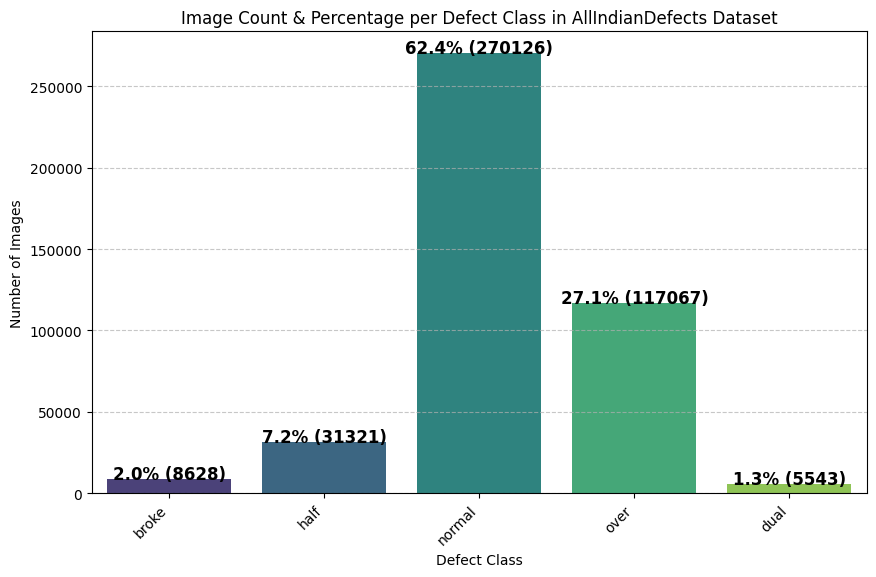

In [12]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the dataset path
dataset_path = "AllIndianDefectsHovernet/"  # Update this if needed

# Dictionary to store image counts per defect class
class_counts = {}

# Loop through each defect class folder
for defect_class in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, defect_class)

    if os.path.isdir(class_path):  # Check if it's a folder
        # Count number of image files inside each defect class folder
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        
        # Store the count
        class_counts[defect_class] = num_images

# Convert dictionary to lists for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Calculate total images and percentage for each class
total_images = sum(counts)
percentages = [(count / total_images) * 100 for count in counts]

# Plot the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=classes, y=counts, palette="viridis")

# Add percentage labels on top of each bar
for i, (count, percent) in enumerate(zip(counts, percentages)):
    ax.text(i, count + 1, f"{percent:.1f}% ({count})", ha='center', fontsize=12, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")
plt.xlabel("Defect Class")
plt.ylabel("Number of Images")
plt.title("Image Count & Percentage per Defect Class in AllIndianDefectsHovernet Dataset")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


